# Affine transforms
Here we compare performance of affine transforms implemented in [cupy](https://cupy.dev), [scipy](https://scipy.org) and clEsperanto

**Note:** benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import pyclesperanto_prototype as cle

import time
from skimage.io import imread, imshow


In [2]:
# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [3]:
image = imread('../data/Haase_MRT_tfl3d1.tif')[60]

(160, 160)

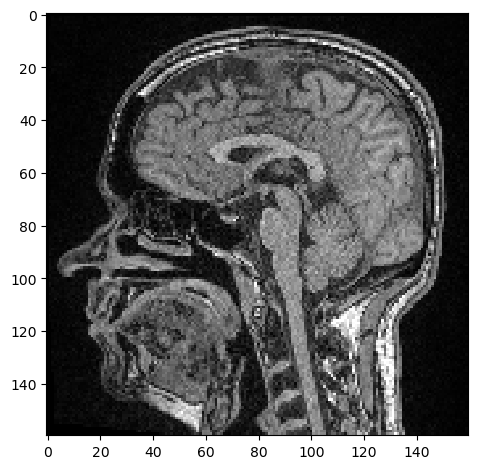

In [4]:
imshow(image)
image.shape

In [5]:
import numpy as np

# scaling by factor 1 / s
s = 0.025
matrix = np.asarray([
    [s, 0, 0],
    [0, s, 0],
    [0, 0, 1],
])
output_shape = tuple((np.asarray(image.shape) / s).astype(int))
print(output_shape)


(6400, 6400)


## clEsperanto - with hardware interpolation

Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transform (hardware interpolation) duration: 0.024105310440063477
Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transform (hardware interpolation) duration: 0.003843069076538086
Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transform (hardware interpolation) duration: 0.0026102066040039062
Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transform (hardware interpolation) duration: 0.003065824508666992
Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transform (hardware interpolation) duration: 0.0026264190673828125
Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transform (hardware interpolation) duration: 0.003042936325073242
Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transform (hardware interpolation) duration: 0.0026276111602783203
Executing affine_transform_2d_interpolate_x.cl
clEsperanto affine transfo

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


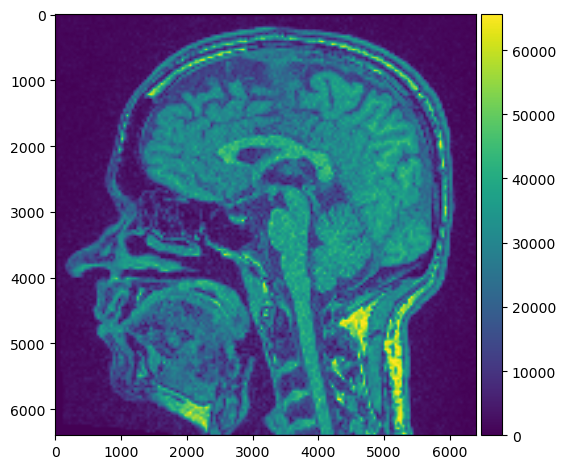

In [6]:
ocl_image = cle.push(image)

ocl_scaled = cle.create(output_shape)
for i in range(0, 10):
    start_time = time.time()
    cle.affine_transform(ocl_image, ocl_scaled, transform=np.linalg.inv(matrix), linear_interpolation=True)
    print("clEsperanto affine transform (hardware interpolation) duration: " + str(time.time() - start_time))

result = cle.pull(ocl_scaled)
imshow(result)

## clEsperanto - with software interpolation (in the future)

Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.030596494674682617
Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.002004861831665039
Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.0020058155059814453
Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.0020067691802978516
Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.0020034313201904297
Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.0020055770874023438
Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.0020051002502441406
Executing affine_transform_2d_x.cl
clEsperanto affine transform (software interpolation) duration: 0.002007722854614258
Executing affine_transform_2d_x.cl


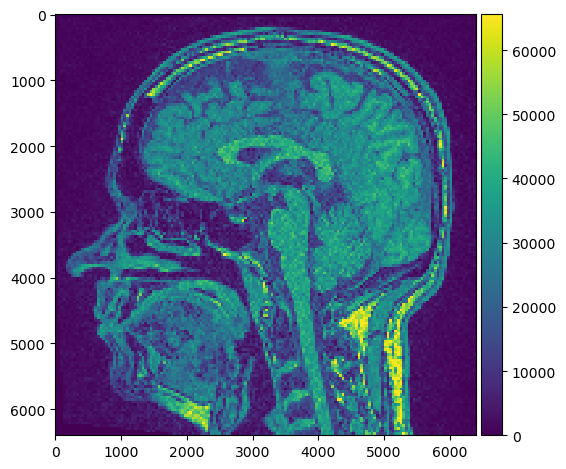

In [7]:
ocl_image = cle.push(image)

ocl_scaled = cle.create(output_shape)
for i in range(0, 10):
    start_time = time.time()
    cle.affine_transform(ocl_image, ocl_scaled, transform=np.linalg.inv(matrix))
    print("clEsperanto affine transform (software interpolation) duration: " + str(time.time() - start_time))

result = cle.pull(ocl_scaled)
imshow(result)

## Scipy

scipy affine transform duration: 2.5551183223724365
scipy affine transform duration: 2.654355764389038
scipy affine transform duration: 2.5812535285949707
scipy affine transform duration: 2.6160848140716553
scipy affine transform duration: 2.632265567779541
scipy affine transform duration: 2.6256587505340576
scipy affine transform duration: 2.623028516769409
scipy affine transform duration: 2.627692937850952
scipy affine transform duration: 2.5552175045013428
scipy affine transform duration: 2.627354860305786


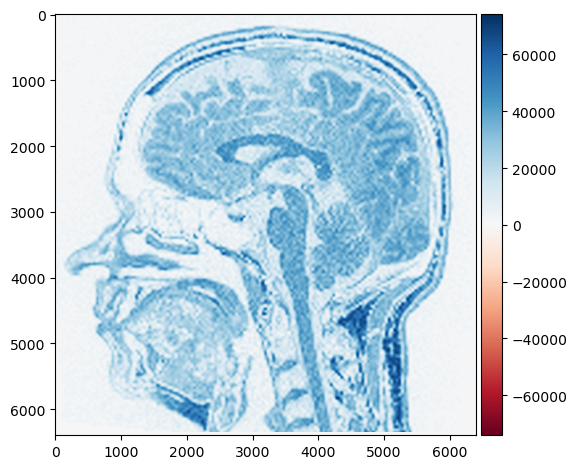

In [8]:
import time
from scipy import ndimage as sndi

scaled = np.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    sndi.affine_transform(image, matrix, output=scaled, output_shape=output_shape)
    print("scipy affine transform duration: " + str(time.time() - start_time))

imshow(scaled)

## cupy

cupy affine transform duration: 0.2559497356414795
cupy affine transform duration: 0.11270904541015625
cupy affine transform duration: 0.12611103057861328
cupy affine transform duration: 0.09901976585388184
cupy affine transform duration: 0.12663793563842773
cupy affine transform duration: 0.11409521102905273
cupy affine transform duration: 0.11233329772949219
cupy affine transform duration: 0.11313319206237793
cupy affine transform duration: 0.11288142204284668
cupy affine transform duration: 0.11177444458007812


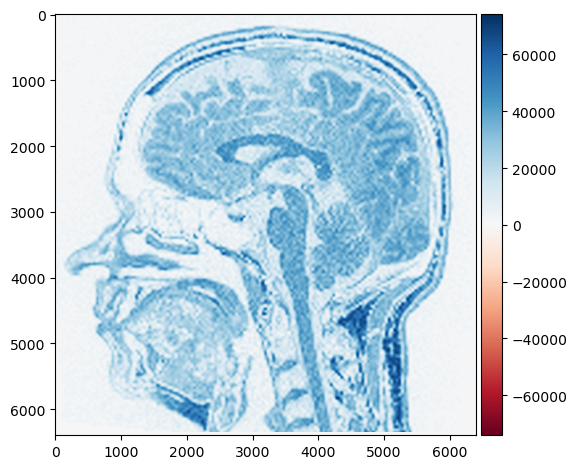

In [9]:

import cupy
from cupyx.scipy import ndimage as ndi

cuda_image = cupy.asarray(image)

cuda_scaled = cupy.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    ndi.affine_transform(cuda_image, cupy.asarray(matrix), output=cuda_scaled, output_shape=output_shape)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy affine transform duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_scaled)
imshow(result)